In [4]:
#installation of apache spark
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!wget -q https://downloads.apache.org/spark/spark-3.5.0/spark-3.5.0-bin-hadoop3.tgz
!tar xf spark-3.5.0-bin-hadoop3.tgz
!pip install -q pyspark

E: Failed to fetch http://security.ubuntu.com/ubuntu/pool/universe/o/openjdk-8/openjdk-8-jre-headless_8u462-ga%7eus1-0ubuntu2%7e22.04.2_amd64.deb  404  Not Found [IP: 185.125.190.81 80]
E: Failed to fetch http://security.ubuntu.com/ubuntu/pool/universe/o/openjdk-8/openjdk-8-jdk-headless_8u462-ga%7eus1-0ubuntu2%7e22.04.2_amd64.deb  404  Not Found [IP: 185.125.190.81 80]
E: Unable to fetch some archives, maybe run apt-get update or try with --fix-missing?
tar: spark-3.5.0-bin-hadoop3.tgz: Cannot open: No such file or directory
tar: Error is not recoverable: exiting now


In [5]:
#starting spark session
from pyspark.sql import SparkSession

spark = SparkSession.builder \
    .appName("AmazonSalesETL") \
    .getOrCreate()

print(" Spark Session Started!")




 Spark Session Started!


In [6]:
from google.colab import files
uploaded = files.upload()

# Automatically detect uploaded file name
file_name = list(uploaded.keys())[0]
print(" Uploaded File:", file_name)

Saving amazon.csv to amazon (1).csv
 Uploaded File: amazon (1).csv


In [7]:
#load data into spark
df = spark.read.csv(file_name, header=True, inferSchema=True)

print("\n Showing first 5 rows of the dataset:")
df.show(5)

print("\n Schema of the dataset:")
df.printSchema()


 Showing first 5 rows of the dataset:
+----------+--------------------+--------------------+----------------+------------+-------------------+------+------------+---------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+
|product_id|        product_name|            category|discounted_price|actual_price|discount_percentage|rating|rating_count|        about_product|             user_id|           user_name|           review_id|        review_title|      review_content|            img_link|        product_link|
+----------+--------------------+--------------------+----------------+------------+-------------------+------+------------+---------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+
|B07JW9H4J1|Wayona Nylon Brai...|Computers&Accesso...|            ₹399|      ₹1

In [10]:
#data cleaning

from pyspark.sql.functions import col, regexp_replace, when, sum

print(" Starting Data Cleaning...")

# Drop duplicates
df = df.dropDuplicates()

# Drop missing rows
df = df.na.drop()

# Clean currency columns
currency_cols = ["discounted_price", "actual_price"]

for c in currency_cols:
    df = df.withColumn(c, regexp_replace(col(c), "[₹,]", ""))
    df = df.withColumn(c, col(c).cast("double"))

print(" Currency cleaned!\n")

# ---------------------------------------

🔧 Starting Data Cleaning...
✔ Currency cleaned!



In [13]:
#adding new column

# Discount amount
df = df.withColumn("discount_amount", col("actual_price") - col("discounted_price"))

# Rating category
df = df.withColumn(
    "rating_category",
    when(col("rating") >= 4, "Excellent")
    .when(col("rating") >= 3, "Good")
    .otherwise("Poor")
)

# Discount ratio
df = df.withColumn(
    "discount_ratio",
    (col("discount_amount") / col("actual_price")) * 100
)

print(" Added discount_amount, rating_category, discount_ratio!\n")

 Added discount_amount, rating_category, discount_ratio!



In [14]:
#final cleaned data

final_df = df.select(
    "product_id",
    "product_name",
    "category",
    "actual_price",
    "discounted_price",
    "discount_amount",
    "discount_ratio",
    "discount_percentage",
    "rating",
    "rating_category",
    "rating_count",
    "product_link"
)

print(" Final Cleaned Dataset:")
final_df.show(10)


 Final Cleaned Dataset:
+----------+--------------------+--------------------+------------+----------------+---------------+------------------+-------------------+------+---------------+------------+--------------------+
|product_id|        product_name|            category|actual_price|discounted_price|discount_amount|    discount_ratio|discount_percentage|rating|rating_category|rating_count|        product_link|
+----------+--------------------+--------------------+------------+----------------+---------------+------------------+-------------------+------+---------------+------------+--------------------+
|B09RX1FK54|boAt Type C A750 ...|Computers&Accesso...|       999.0|           399.0|          600.0| 60.06006006006006|                60%|   4.1|      Excellent|       1,780|https://www.amazo...|
|B097JVLW3L|Irusu Play VR Plu...|Electronics|HomeT...|      3500.0|          2699.0|          801.0|22.885714285714286|                23%|   3.5|           Good|         621|https://www.a

In [16]:


print("\n Saving cleaned dataset...")

final_df.write.csv("/content/clean_amazon_products_csv", header=True, mode="overwrite")
final_df.write.parquet("/content/clean_amazon_products_parquet", mode="overwrite")

print(" ETL Pipeline Completed Successfully!")



 Saving cleaned dataset...
 ETL Pipeline Completed Successfully!


/tmp/ipython-input-3971994783.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pdf["rating"] = pd.to_numeric(pdf["rating"], errors="coerce")
/tmp/ipython-input-3971994783.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pdf["discount_ratio"] = pd.to_numeric(pdf["discount_ratio"], errors="coerce")
/tmp/ipython-input-3971994783.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in t

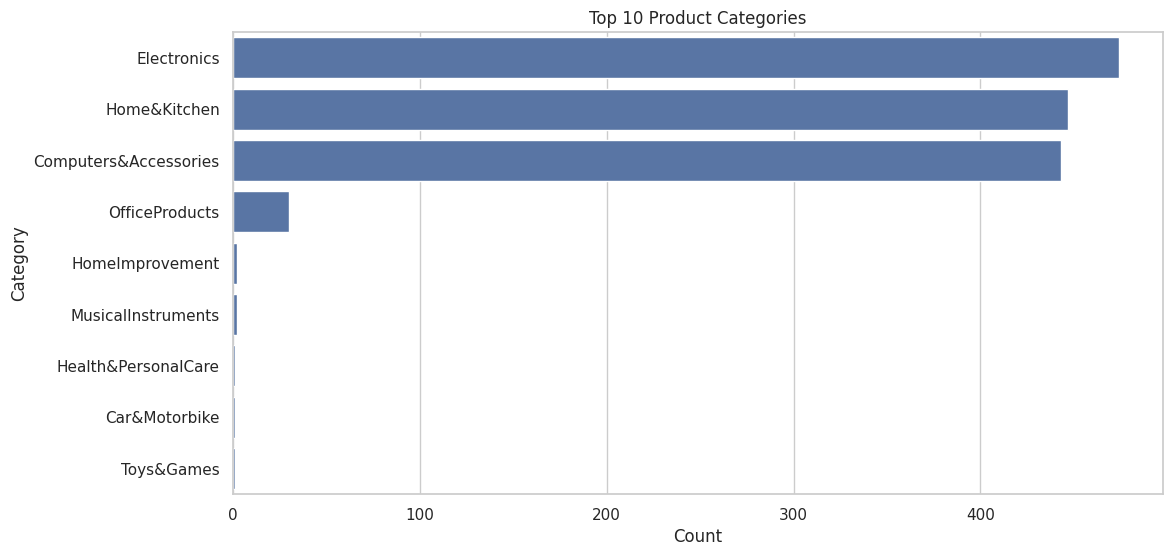

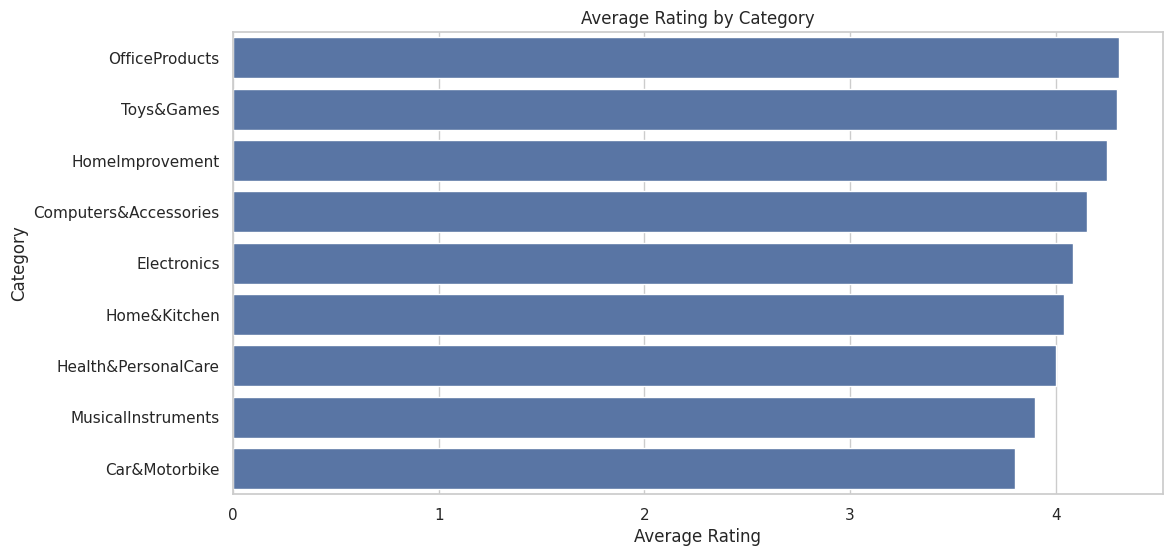

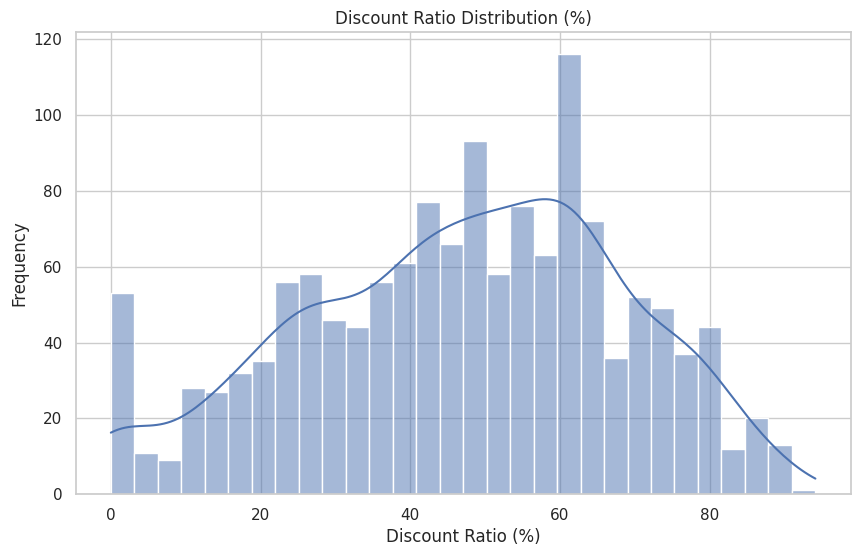

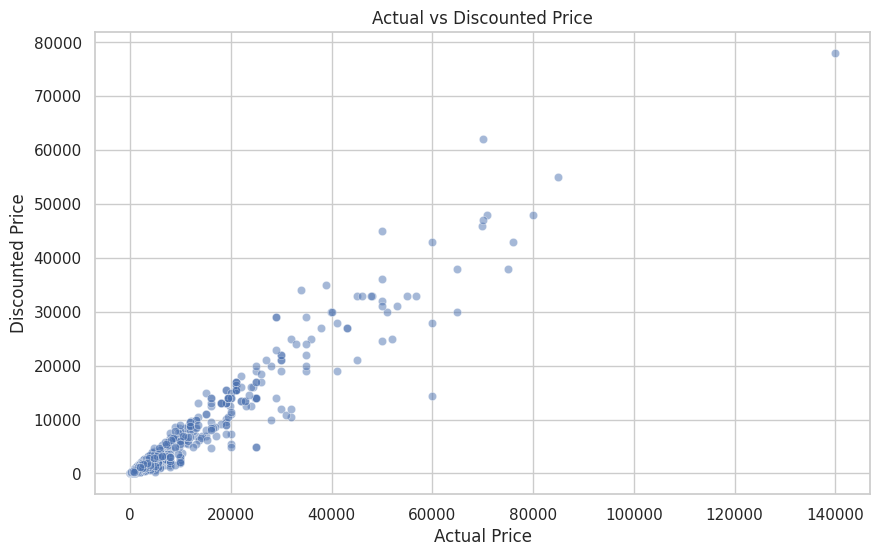

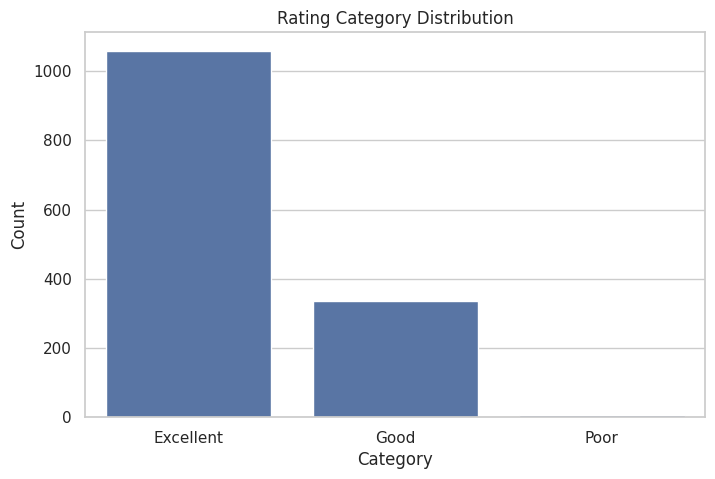

In [20]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style="whitegrid")

# Clean numeric columns

pdf["rating"] = pd.to_numeric(pdf["rating"], errors="coerce")
pdf["discount_ratio"] = pd.to_numeric(pdf["discount_ratio"], errors="coerce")
pdf["discount_amount"] = pd.to_numeric(pdf["discount_amount"], errors="coerce")

pdf = pdf.dropna(subset=["rating", "discount_ratio", "discount_amount"])


# Clean categories

pdf["main_category"] = pdf["category"].str.split("|").str[0]


# 1️ Top 10 Categories

plt.figure(figsize=(12,6))
sns.countplot(data=pdf, y="main_category", order=pdf["main_category"].value_counts().index[:10])
plt.title("Top 10 Product Categories")
plt.xlabel("Count")
plt.ylabel("Category")
plt.show()


# 2️ Average Rating per Category

plt.figure(figsize=(12,6))
rating_avg = pdf.groupby("main_category")["rating"].mean().sort_values(ascending=False)[:10]
sns.barplot(x=rating_avg.values, y=rating_avg.index)
plt.title("Average Rating by Category")
plt.xlabel("Average Rating")
plt.ylabel("Category")
plt.show()


# 3️ Discount Ratio Distribution

plt.figure(figsize=(10,6))
sns.histplot(pdf["discount_ratio"], bins=30, kde=True)
plt.title("Discount Ratio Distribution (%)")
plt.xlabel("Discount Ratio (%)")
plt.ylabel("Frequency")
plt.show()

# 4️ Price Comparison

plt.figure(figsize=(10,6))
sns.scatterplot(data=pdf, x="actual_price", y="discounted_price", alpha=0.5)
plt.title("Actual vs Discounted Price")
plt.xlabel("Actual Price")
plt.ylabel("Discounted Price")
plt.show()


# 5️ Rating Category Counts

plt.figure(figsize=(8,5))
sns.countplot(data=pdf, x="rating_category")
plt.title("Rating Category Distribution")
plt.xlabel("Category")
plt.ylabel("Count")
plt.show()


             +----------------------+
             |     Upload CSV       |
             |   (Google Colab)     |
             +----------+-----------+
                        |
                        v
             +----------------------+
             |    Extract (Spark)   |
             |  Load to DataFrame   |
             +----------+-----------+
                        |
                        v
             +-------------------------------+
             |   Transform (PySpark)         |
             | - Clean prices                |
             | - Drop nulls                  |
             | - New fields: discount, etc.  |
             +----------+--------------------+
                        |
                        v
             +----------------------+
             |   Load Clean Data    |
             | CSV + Parquet Files  |
             +----------+-----------+
                        |
                        v
             +----------------------+
             |     Dashboard        |
             |  Matplotlib/Seaborn  |
             +----------------------+
